In [198]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u252-b09-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
!pip install PyDrive
!pip install geopandas
import re

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from geopy.geocoders import Nominatim
from google.colab import files
import io
import plotly.graph_objects as go
import seaborn as sns

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#idf = '1PN6TbhTwwl-hVII3P89IMbs1ashJ7BYz'
idf = '1QQ7k1Y5RvL0ZcnQuTVg0rHU6O5AK81zQ'
downloaded = drive.CreateFile({'id':idf})   # replace the id with id of file you want to access
downloaded.GetContentFile('flights.parquet') 
# Fuente del dataset: https://www.kaggle.com/divyansh22/flight-delay-prediction

In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
import pandas as pd
from pyspark.sql import SQLContext, SparkSession
from collections import Counter
from textblob import TextBlob
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

Trabajo Practico

In [204]:
uploaded=files.upload()

Saving traintp.csv to traintp (2).csv
Saving twiter_with_data_location.csv to twiter_with_data_location (2).csv


In [0]:
twiter_my=pd.read_csv(io.BytesIO(uploaded["twiter_with_data_location.csv"]))

In [206]:
twiter_my.loc[(twiter_my.location_isnull == False)&(twiter_my.location_free.isnull() == False )].head(3)

,Unnamed: 0,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country
31,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,False,Birmingham,"['Birmingham, West Midlands Combined Authority...",52.479699,-1.902691,Birmingham,United Kingdom
32,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False,Est September 2012 Bristol,"(None, None, None)",NaN,NaN,NaN,NaN
33,33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,False,AFRICA,"['Africa', 11.5024338, 17.7578122]",11.502434,17.757812,Africa,Africa


Bool que me indica si algun campo de la locacion en nula para poder manejar el erro del geopandas

In [0]:
twiter_my["locacion_isnull"]=twiter_my.location.isnull()
#tweets_with_clean_location.head(5)

Analisis de Sentimiento del texto


In [0]:
def subjectivityText(x):
  t=TextBlob(x)
  return t.sentiment.subjectivity

In [0]:
def polarityText(x):
  t=TextBlob(x)
  return t.sentiment.polarity

# OBTENCION DE LA POLARIDAD Y LA SUBJETIVIDAD PARA CADA TEXTO DEL DATA FRAME

In [0]:
#twiter_my["subjectivity_text"]=twiter_my.loc[twiter_my.location_free.isnull()==False].text.transform(subjectivityText)
twiter_my["subjectivity_text"]=twiter_my.text.transform(subjectivityText)

In [0]:
#twiter_my["polarity_text"]=twiter_my.loc[twiter_my.location_free.isnull()==False].text.transform(polarityText)
twiter_my["polarity_text"]=twiter_my.text.transform(polarityText)

Text(0.5, 1.0, 'Distribucion general de la Polaridad y Subjetividad de todo los Textos')

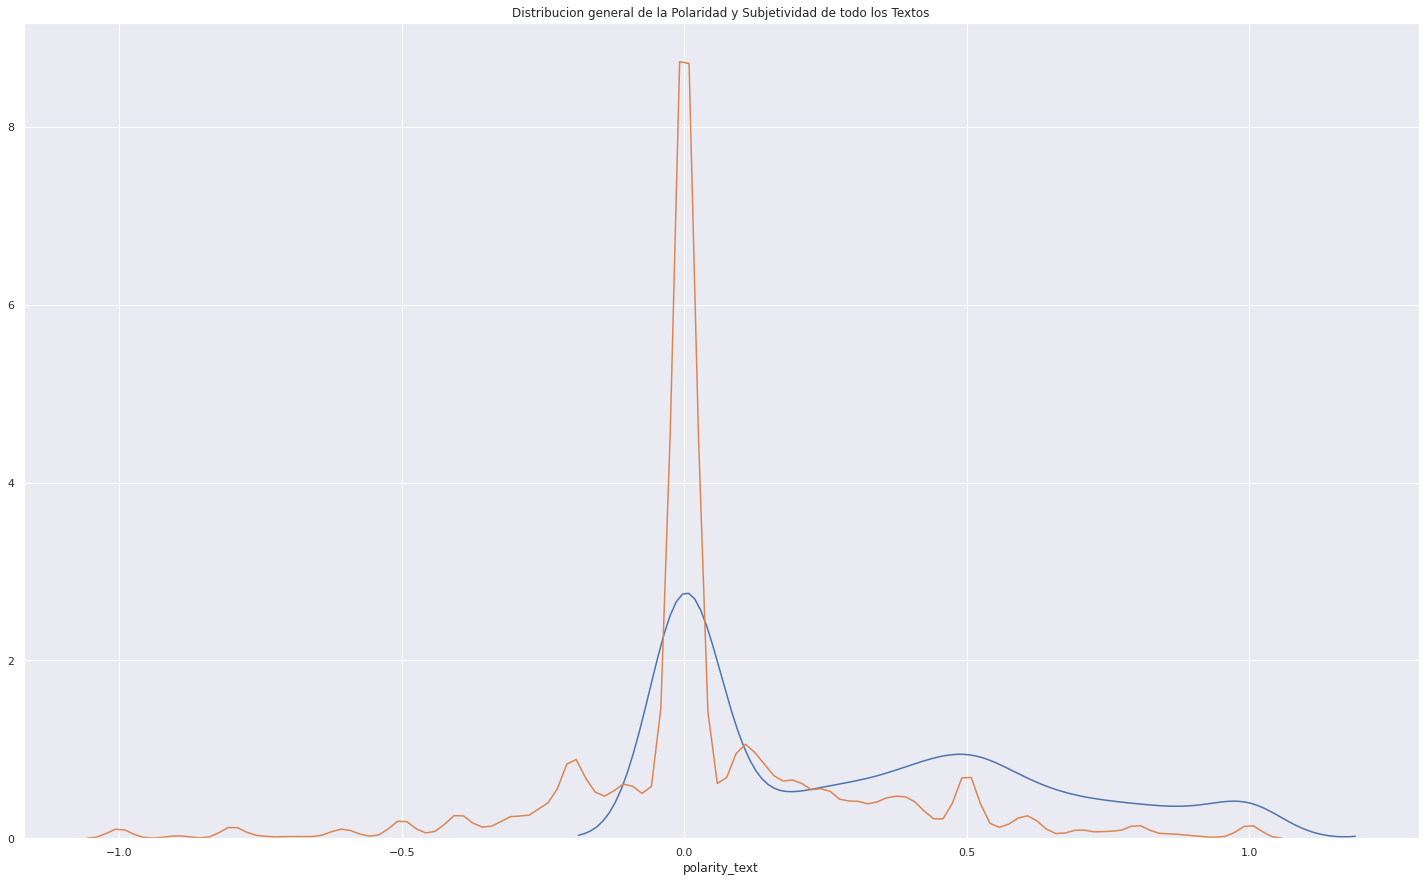

In [288]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (25, 15))
g=sns.distplot(twiter_my.loc[twiter_my.location_free.isnull()==False]["subjectivity_text"],ax = ax,hist=False)
g=sns.distplot(twiter_my.loc[twiter_my.location_free.isnull()==False]["polarity_text"],ax = ax,hist=False)
g.set_title("Distribucion general de la Polaridad y Subjetividad de todo los Textos")

In [0]:
def analisis_del_sentimiento(x):
  if x==0:
     return 0
  if x>0:
     return 1
  if x<0 :
    return -1

In [0]:
twiter_my["polaridad_magnitud"]=twiter_my.polarity_text.transform(analisis_del_sentimiento)

In [0]:
twiter_my["subjectivity_magnitud"]=twiter_my.subjectivity_text.transform(analisis_del_sentimiento)

In [216]:
twiter_my_sin_null=twiter_my.loc[twiter_my.location_free.isnull()==False]
twiter_my_sin_null.head(2)

,Unnamed: 0,id,keyword,location,text,target,location_isnull,location_free,address_latitude_longitude,latitude,longitude,city,country,locacion_isnull,subjectivity_text,polarity_text,polaridad_magnitud,subjectivity_magnitud
31,31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,False,Birmingham,"['Birmingham, West Midlands Combined Authority...",52.479699,-1.902691,Birmingham,United Kingdom,False,0.0,0.0,0.0,0.0
32,32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,False,Est September 2012 Bristol,"(None, None, None)",NaN,NaN,NaN,NaN,False,0.5,-0.2,-1.0,1.0


In [0]:
#ax = sns.barplot(y="country",x="subjectivity_magnitud", hue="subjectivity_magnitud", data=twiter_my_sin_null)
#sns.distplot(tweets_text.loc[tweets_text.target== True,'NOMBRE COLUMNA'],  hist=False, label='Reales', bins =20)
#sns.distplot(tweets_text.loc[tweets_text.target== False,'NOMBRE COLUMNA'],  hist=False, label='Falsos',bins = 20)

# OBTENGO DE LA CANTIDAD ,DE TEXTOS CON POLARIDAD O SUBJE ,POS NEG NEU

In [0]:
def pos(x):
  count =0
  for y in x :
    if(y>0.5):
      count=count+1
  return count

In [0]:
def neg(x):
  count =0
  for y in x :
    if(y<-0.5):
      count=count+1
  return count

In [0]:
def neu(x):
  count =0
  for y in x :
    if( (y>=(-0.5))and(y<=0.5)):
      count=count+1
  return count

# ANALIZO SOLO EN LOS TEXTOS CON LOCACIONES LA PARTE POS NEG NEU DE LA POLARIDAD

In [319]:
twiter_my_polarity=twiter_my.loc[twiter_my.location_free.isnull()==False].groupby("country").agg({"polarity_text":[pos,neg,neu,"mean","max","min"],"subjectivity_text":[pos,neg,neu,"mean","max","min"],"text":["count"]})
#.sort_values(by=['polarity_text'],ascending=False)
twiter_my_polarity

polarity_text             ... subjectivity_text            text
                      pos  neg   neu  ...               max       min count
country                               ...                                  
 Argentina            0.0  0.0  12.0  ...          0.900000  0.000000    12
 Armenia              0.0  0.0   1.0  ...          0.734848  0.734848     1
 Australia            2.0  3.0  97.0  ...          1.000000  0.000000   102
 Bangladesh           0.0  0.0   3.0  ...          0.400000  0.000000     3
 Barbados             0.0  0.0   3.0  ...          0.400000  0.000000     3
...                   ...  ...   ...  ...               ...       ...   ...
ประเทศไทย             0.0  0.0   3.0  ...          0.178571  0.000000     3
ປະເທດລາວ              0.0  0.0   6.0  ...          0.500000  0.000000     6
中国                    2.0  0.0   5.0  ...          0.620909  0.495833     7
日本                    1.0  0.0   4.0  ...          0.573810  0.000000     5
대한민국                  0.0  0.0   2.0  ...          0.613636  0.100000     2

[185 rows x 13 columns]

In [0]:
level0=twiter_my_polarity.columns.get_level_values(0)
level1=twiter_my_polarity.columns.get_level_values(1)
twiter_my_polarity.columns=level0 + "_" + level1
twiter_my_polarity.reset_index(inplace=True)

In [322]:

twiter_my_polarity

,country,polarity_text_pos,polarity_text_neg,polarity_text_neu,polarity_text_mean,polarity_text_max,polarity_text_min,subjectivity_text_pos,subjectivity_text_neg,subjectivity_text_neu,subjectivity_text_mean,subjectivity_text_max,subjectivity_text_min,text_count
0,Argentina,0.0,0.0,12.0,0.027778,0.300000,-0.200000,2.0,0.0,10.0,0.214683,0.900000,0.000000,12
1,Armenia,0.0,0.0,1.0,0.003788,0.003788,0.003788,1.0,0.0,0.0,0.734848,0.734848,0.734848,1
2,Australia,2.0,3.0,97.0,0.001320,0.850000,-1.000000,19.0,0.0,83.0,0.278489,1.000000,0.000000,102
3,Bangladesh,0.0,0.0,3.0,0.133333,0.300000,0.000000,0.0,0.0,3.0,0.250000,0.400000,0.000000,3
4,Barbados,0.0,0.0,3.0,0.066667,0.100000,0.000000,0.0,0.0,3.0,0.266667,0.400000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,ประเทศไทย,0.0,0.0,3.0,0.003968,0.011905,0.000000,0.0,0.0,3.0,0.059524,0.178571,0.000000,3
181,ປະເທດລາວ,0.0,0.0,6.0,0.127778,0.500000,0.000000,0.0,0.0,6.0,0.172222,0.500000,0.000000,6
182,中国,2.0,0.0,5.0,0.294079,0.535714,0.034091,5.0,0.0,2.0,0.569638,0.620909,0.495833,7
183,日本,1.0,0.0,4.0,0.131310,0.535714,-0.250000,1.0,0.0,4.0,0.263929,0.573810,0.000000,5


In [323]:
twiter_my_polarity_top10=twiter_my_polarity.sort_values(by=['text_count'],ascending=False).head(10)
twiter_my_polarity_top10

,country,polarity_text_pos,polarity_text_neg,polarity_text_neu,polarity_text_mean,polarity_text_max,polarity_text_min,subjectivity_text_pos,subjectivity_text_neg,subjectivity_text_neu,subjectivity_text_mean,subjectivity_text_max,subjectivity_text_min,text_count
84,United States of America,91.0,43.0,1766.0,0.056509,1.00,-1.000,513.0,0.0,1387.0,0.306274,1.0,0.0,1900
83,United Kingdom,17.0,10.0,392.0,0.038399,1.00,-1.000,127.0,0.0,292.0,0.325834,1.0,0.0,419
10,Canada,15.0,2.0,208.0,0.075309,1.00,-0.800,56.0,0.0,169.0,0.281136,1.0,0.0,225
157,United States,7.0,1.0,163.0,0.034430,0.70,-0.800,30.0,0.0,141.0,0.231139,1.0,0.0,171
28,India,6.0,5.0,100.0,0.077690,0.80,-1.000,44.0,0.0,67.0,0.440703,1.0,0.0,111
2,Australia,2.0,3.0,97.0,0.001320,0.85,-1.000,19.0,0.0,83.0,0.278489,1.0,0.0,102
156,United Kingdom,4.0,2.0,41.0,0.070309,1.00,-0.900,16.0,0.0,31.0,0.382617,1.0,0.0,47
24,France,0.0,2.0,41.0,-0.032655,0.50,-1.000,9.0,0.0,34.0,0.251938,1.0,0.0,43
56,Philippines,4.0,0.0,35.0,0.159063,1.00,-0.200,9.0,0.0,30.0,0.340028,1.0,0.0,39
51,Nigeria,0.0,0.0,38.0,0.034320,0.50,-0.375,7.0,0.0,31.0,0.232566,1.0,0.0,38


Text(0.5, 1.0, 'Analisis de la Polaridad positiva de los Textos por Country')

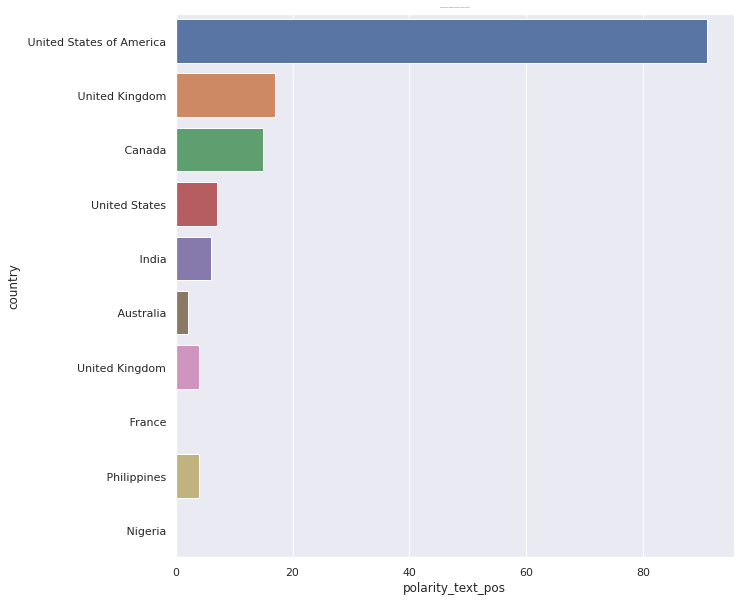

In [324]:
g=sns.barplot(x = "polarity_text_pos", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Polaridad positiva de los Textos por Country",fontsize=1)

Text(0.5, 1.0, 'Analisis de la Polaridad Negativa de los Textos por Country')

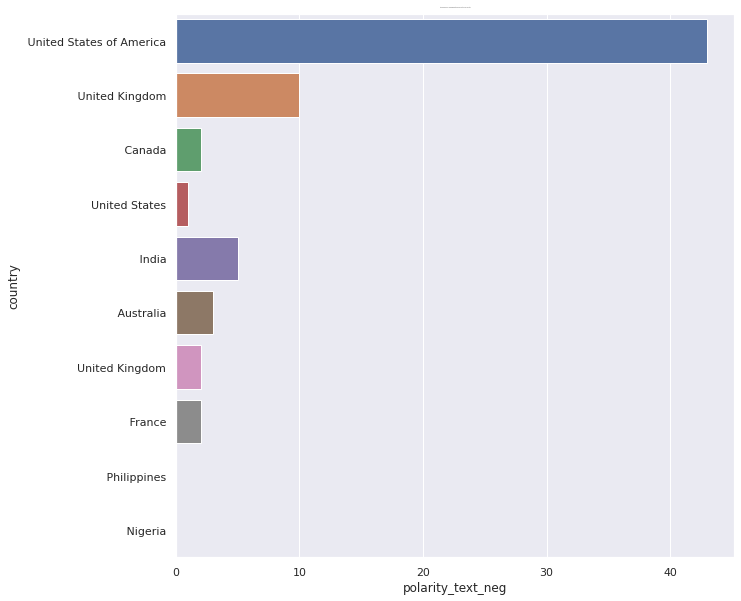

In [325]:
g=sns.barplot(x = "polarity_text_neg", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Polaridad Negativa de los Textos por Country",fontsize=1)

Text(0.5, 1.0, 'Analisis de la Polaridad Neutra de los Textos por Country')

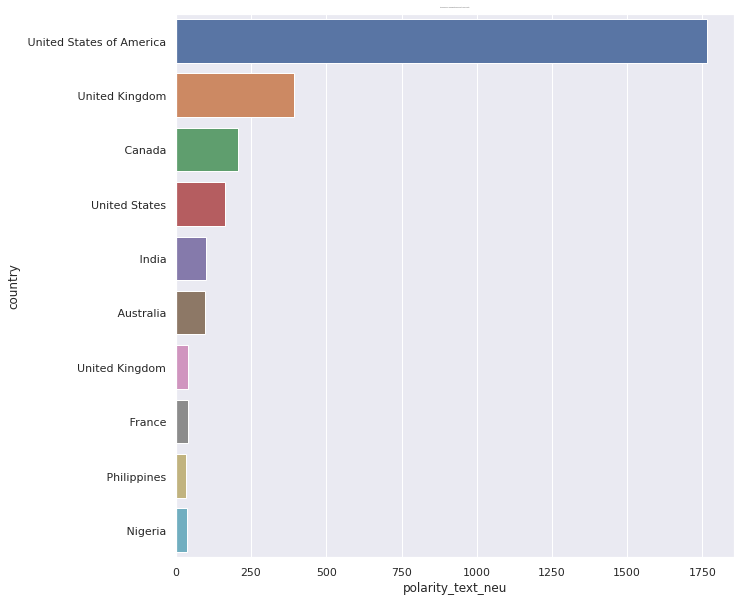

In [326]:
g=sns.barplot(x = "polarity_text_neu", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Polaridad Neutra de los Textos por Country",fontsize=1)

Text(0.5, 1.0, 'Analisis de la Subjetividad positiva de los Textos por Country')

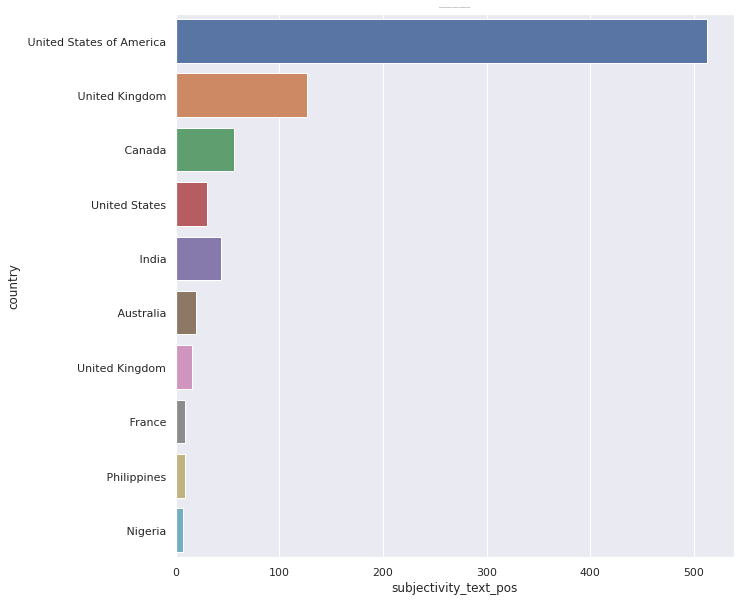

In [329]:
g=sns.barplot(x = "subjectivity_text_pos", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Subjetividad positiva de los Textos por Country",fontsize=1)

Text(0.5, 1.0, 'Analisis de la Subjetividad negativa de los Textos por Country')

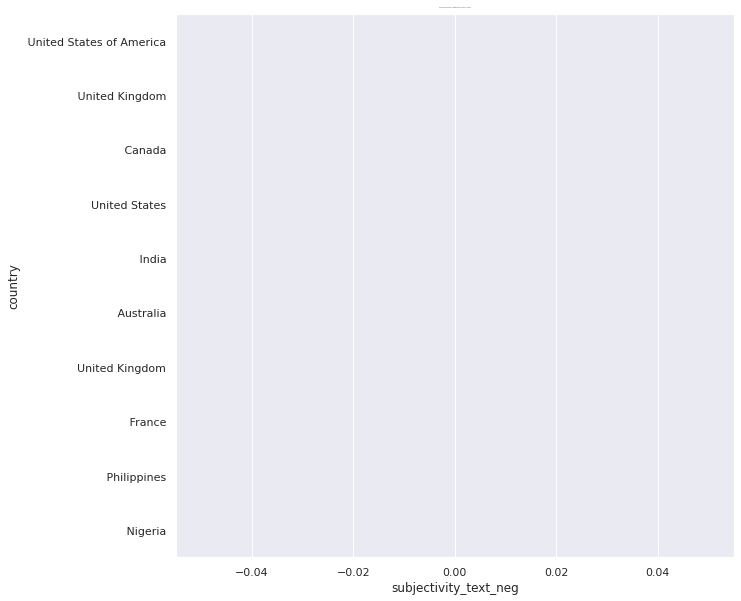

In [330]:
g=sns.barplot(x = "subjectivity_text_neg", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Subjetividad negativa de los Textos por Country",fontsize=1)

Text(0.5, 1.0, 'Analisis de la Subjetividad neutra de los Textos por Country')

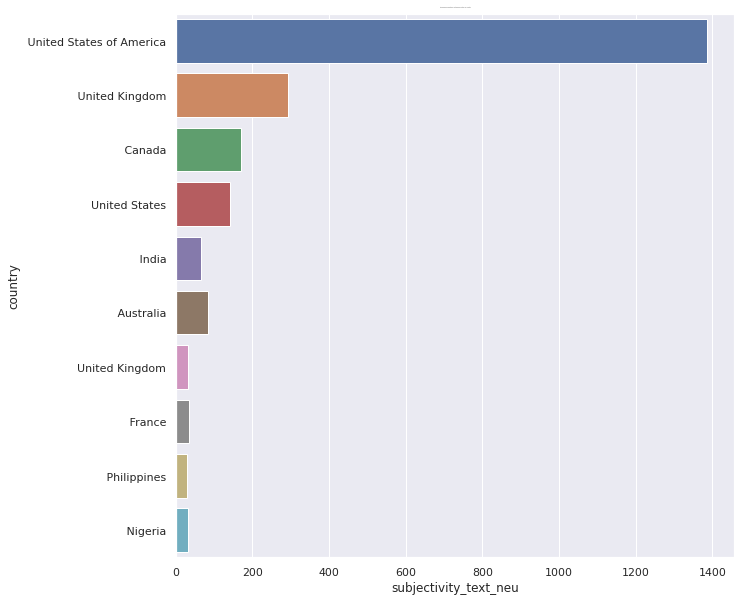

In [331]:
g=sns.barplot(x = "subjectivity_text_neu", y = 'country', data = twiter_my_polarity_top10)
g.set_title("Analisis de la Subjetividad neutra de los Textos por Country",fontsize=1)

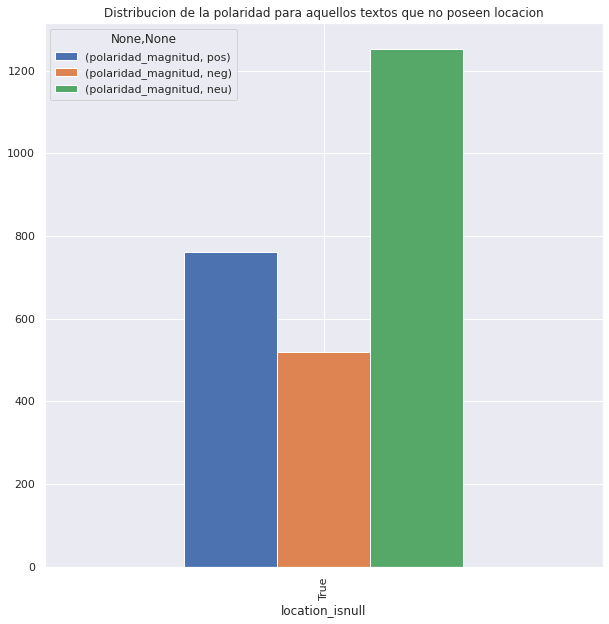

In [327]:
twiter_my_sinlocation=twiter_my.loc[twiter_my.location_isnull==True]
twiter_my_sinlocation_info=twiter_my_sinlocation.groupby("location_isnull").agg({"polaridad_magnitud":[pos,neg,neu]})
twiter_my_sinlocation_info.plot(kind="bar",title="Distribucion de la polaridad para aquellos textos que no poseen locacion")


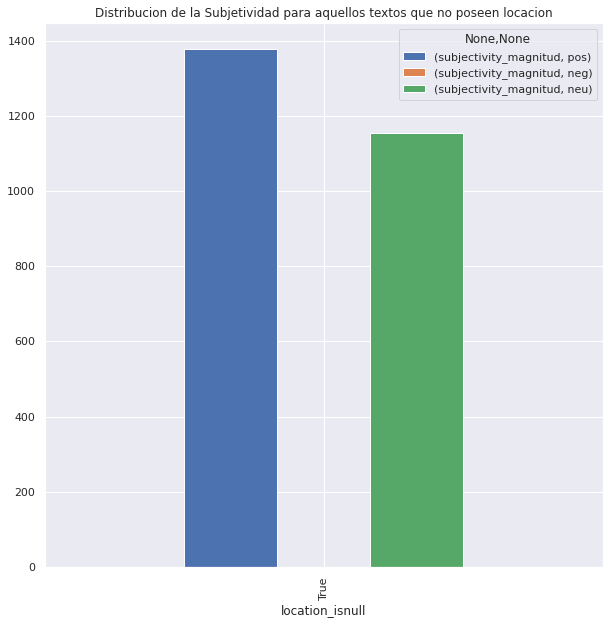

In [328]:
twiter_my_sinlocation_info=twiter_my_sinlocation.groupby("location_isnull").agg({"subjectivity_magnitud":[pos,neg,neu]})
twiter_my_sinlocation_info.plot(kind="bar",title="Distribucion de la Subjetividad para aquellos textos que no poseen locacion")
